In [ ]:
import sys, urllib.request

IS_COLAB = 'google.colab' in sys.modules

    
if IS_COLAB:
    from google.colab import files
    
    #create extra folders
    !mkdir -pv data images models

    # will install missing packages if running in colab
    if 'uproot' not in sys.modules:
        print('Installing uproot...')
        !pip install uproot

    #will download the data if running in colab
    urllib.request.urlretrieve('https://cernbox.cern.ch/index.php/s/GRAyoFxBHAlMVpu/download',
                               'data/events_6D64x64.root')
    urllib.request.urlretrieve('https://cernbox.cern.ch/index.php/s/dZ9r1nvBRTpJMNW/download',
                               'data/events_6D64x64_ATLAS_resolution_6D64x64.root')
    urllib.request.urlretrieve('https://cernbox.cern.ch/index.php/s/dEZGYJgXOjV2ArN/download',
                               'data/events_6D64x64_ATLAS_resolution.root')
    
    print('ls data')
    !ls data/*

    #download additional modules used with the notebook
    !wget https://raw.githubusercontent.com/michael-pitt/AI/master/ParticleImages/train_helpers.py
    !wget https://raw.githubusercontent.com/michael-pitt/AI/master/ParticleImages/particleImages_helpers.py

    print('Using COLAB: all additional packages are installed and the data is downloaded')

# Super resolution notebook

In this notebook, the Super Resolution (SR) will be applied on the detector images. The goal is to reconstruct detector images with higher resolution. In this notebook we will try several approaches for this task.

The input data obtained using the [ATLAS-simplified](https://github.com/mpitt82/Geant4-models/tree/master/ATLAS-simplified) Geant4 simulation model. The bare data files are available [here](https://cernbox.cern.ch/index.php/s/oCg3en1GHAvYSTo?path=%2FCalo_RectangularGeo_diPion64x64%2Frun).

Using the [Vector2Matrix.cc](https://github.com/mpitt82/Geant4-models/blob/master/ATLAS-simplified/scripts/Vector2Matrix.cc) script $6\times 64\times 64$ images are obtaned, then with [Matrix2Matrix6L.cc](https://github.com/mpitt82/Geant4-models/blob/master/ATLAS-simplified/scripts/Matrix2Matrix6L.cc) script Low-resolution images are computed. For democtaric upsaling (used as a first approach) the [Matrix2Matrix6L.cc](https://github.com/mpitt82/Geant4-models/blob/master/ATLAS-simplified/scripts/Matrix6L2Matrix.cc) script can be used. **NOTE** All scripts executed in [CINT](https://root.cern.ch/cint). 


Standards imports

In [32]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from operator import mul

### Loading the data

In this example, we will use two example files from cernbox folder, which have $\sim$2k events.

In [33]:
inputfileHR = 'data/events_6D64x64.root'
inputfileLR = 'data/events_6D64x64_ATLAS_resolution.root'

f = uproot.open(inputfileHR)
treeHR = f['EventTree']

f = uproot.open(inputfileLR)
treeLR = f['EventTree']

print('Total number of events in both files is = '+str(treeHR.numentries)+' (HR) and '+str(treeLR.numentries)+' (LR)')

Total number of events in both files is = 2100 (HR) and 2100 (LR)


### Calorimeter images

In this section, we will create calorimeter images from the cell hits using LR and HR input files. First we will constract a dataset using SRDataLoader defined in [train_helpers.py](train_helpers.py)

In [34]:
from train_helpers import SRDataLoaderLayers

In [35]:
#for now we will use the full data to validate the model
train_dataset = SRDataLoaderLayers(treeLR, treeHR)
test_dataset  = SRDataLoaderLayers(treeLR, treeHR)

Draw a random image from the energy matrices:

In [36]:
from particleImages_helpers import DrawEventSR

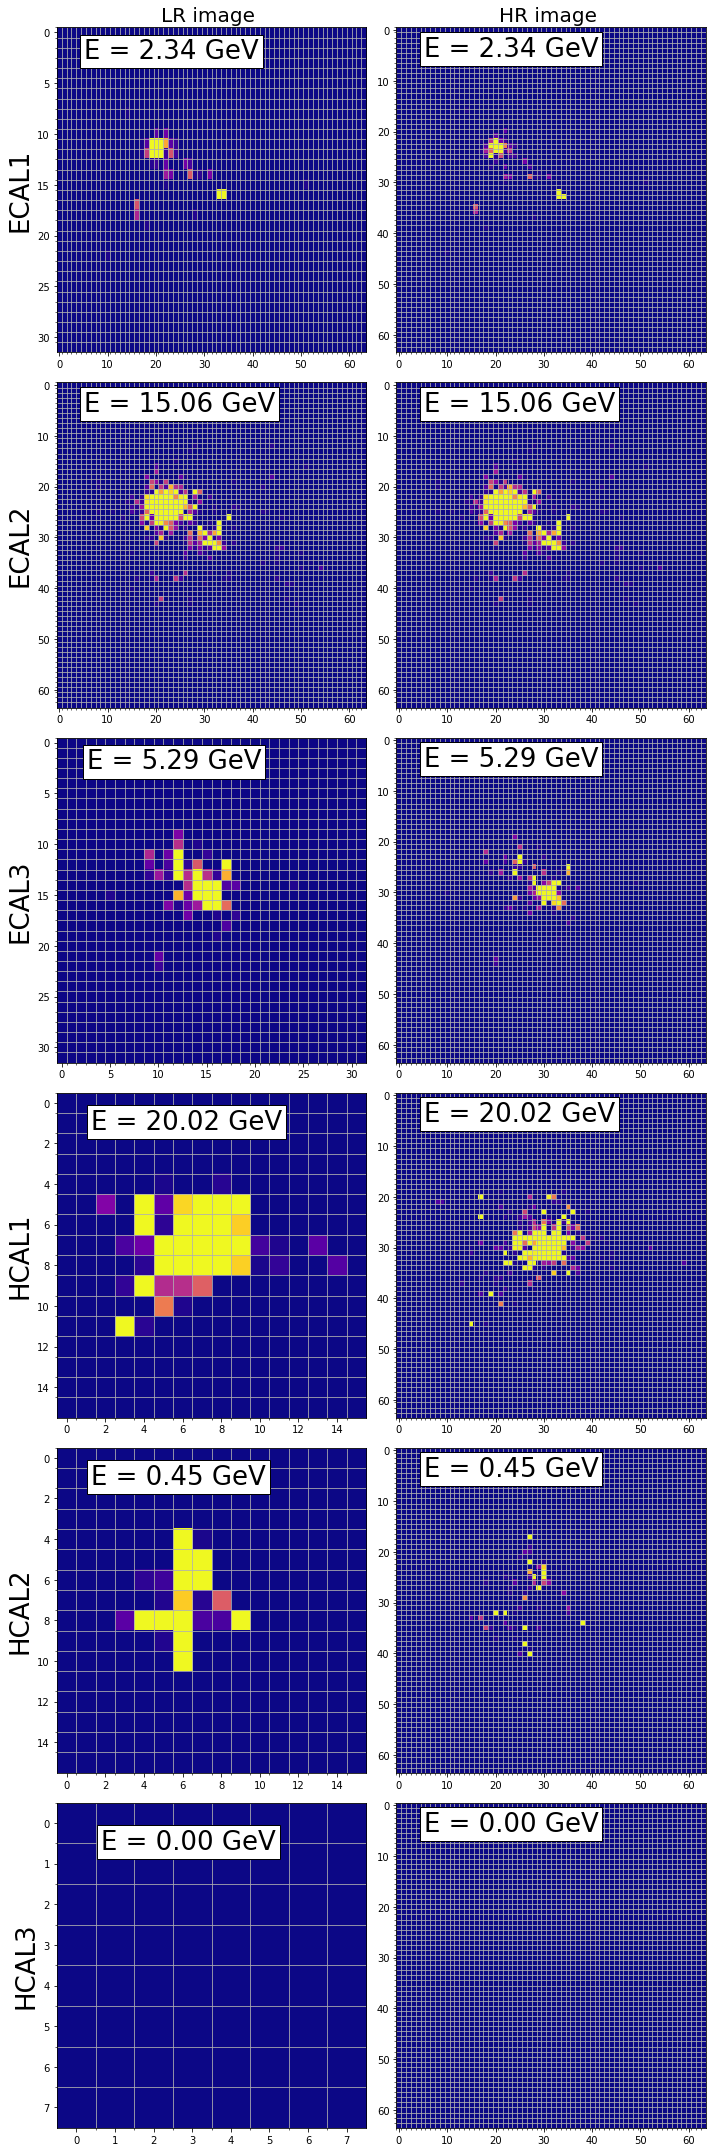

In [37]:
DrawEventSR(train_dataset, event_number = 123)

### Model

The model consists of a custom Conv layers. Each layer is based on the size of the LR pixel image, and it uses the information by looking at the neighbor pixes on all layers around it. Then we build NN to learn from the neighbors how the energy that is measured in a single-pixel should look when we increase the granularity. 

It is a three-step calculation:

  * convolution
  * softmax on the output dimensions
  * broadcast multiplication between LR image and the obtained weights from step 2

First, we scan the image using slicing window, and compute the following function: $Y = X \times w$, where the $X$ is the image representation of a slicing window (which include all pixels from all layers around of a given pixel),$w$ is the weight matrix. The weight matrix has dimensions of $dim(X) \times S$, where the $S$ is the scale parameter defined by the ratio between $HR$ and $LR$ images. Then a softmax function is applied among the last dimension of the output matrix $Y$. 

In [38]:
device_number = 0; #change this value to "1" if using the second GPU
use_cuda = torch.cuda.is_available()
print('Availability of CUDA:',use_cuda)
print('Availability of CUNN:',torch.backends.cudnn.enabled)
print('Total number of GPU devices: ',torch.cuda.device_count())
device = torch.device("cuda:"+str(device_number) if torch.cuda.is_available() else "cpu")
if use_cuda:
    torch.cuda.set_device(device_number)
    idevice = torch.cuda.current_device()
    print('Will work on device number',idevice,', named: ',torch.cuda.get_device_name(idevice))
else: print('will run on CPU, using',torch.get_num_threads(),'cores')

Availability of CUDA: False
Availability of CUNN: True
Total number of GPU devices:  0
will run on CPU, using 8 cores


Now we create a custom layer, where the convolution is replaced by the new function ($NN\times softmax$) applied on a list of input pixels and returns a map of how a single-pixel should spread to many in the HR image. This map is multiplied with the LR image such that an image with HR resolution is obtained

In [39]:
class NewConv2d(nn.Module):
    def __init__(self, LR_shapes, HR_shape, layer_number, kernel_size = (3,3), padding = (1,1), debug = False):
        super(NewConv2d, self).__init__()
        
        self.upscale_factor = (int(HR_shape[0]/LR_shapes[layer_number][0]),int(HR_shape[1]/LR_shapes[layer_number][1]))
        self.output_dim = self.upscale_factor[0]*self.upscale_factor[1]
        self.kernel = kernel_size
        self.padding = padding
        self.nLayers = len(LR_shapes)
        self.LR_shapes = LR_shapes #shapes of all layers
        self.ls0 = LR_shapes[layer_number]
        self.layer_number = layer_number
        self.debug = debug
        
        #construct weight matrix depend on the layer shape
        if self.output_dim>1:
            weights_input_dim = 0
            for j_layer in range(self.nLayers):
                neigh_Npix = int(LR_shapes[j_layer][0]/LR_shapes[layer_number][0])*int(LR_shapes[j_layer][1]/LR_shapes[layer_number][1])
                weights_input_dim += neigh_Npix * np.prod(kernel_size)
            self.weight = nn.Parameter(torch.rand(weights_input_dim,self.output_dim))
            #self.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input):
        
        # selected layer to apply upscaling
        Xsel = input[self.layer_number]

        #if no upscaling needed, return the layer as it is
        if self.output_dim==1:
            return Xsel
        #convolute the weight matrix with the input layers
        Xunfold = []
        for j_layer in range(self.nLayers):
            s = (int(self.LR_shapes[j_layer][0]/self.ls0[0]),
                int(self.LR_shapes[j_layer][1]/self.ls0[1]))
            if not np.prod(s): continue #skip layer with smaller granularity
            f = tuple(map(mul, self.kernel, s))
            p = tuple(map(mul, self.padding, s))
            Xunfold.append(F.unfold(input[j_layer],kernel_size=f,padding=p,stride=s))
        Xunfold = torch.cat(Xunfold,dim=1)
        out_unf = Xunfold.transpose(1, 2).matmul(self.weight)
        
        #apply softmax on the output dimention
        out_unf_soft = out_unf.softmax(dim=-1)
        out_unf_soft = out_unf_soft[:,:,:,None].transpose(2, 3)
        
        #multiply the input layer with the output weights
        out = F.unfold(Xsel,kernel_size=1).transpose(1, 2)[:,:,:,None]
        out = out.matmul(out_unf_soft)
        out = out.squeeze(2).transpose(1, 2)
        
        #fold back to the input image shape, and expland to the HR image
        out = F.fold(out,self.ls0,1)
        out = self.pixel_shuffle(out)
        return out
    
    def pixel_shuffle(self, input):
        if len(input.shape)<4:
            raise ValueError('Error input layer for shuffling, expect 4D, got'+str(input.shape))
        n = input.shape[0]
        h = input.shape[2]
        w = input.shape[3]
        if input.shape[1]!=self.upscale_factor[0]*self.upscale_factor[1]:
            raise ValueError('Error input dim,',input.shape,' will not work with upscale_factor',self.upscale_factor)
        #output
        oh = h * self.upscale_factor[0];
        ow = w * self.upscale_factor[1];
        input_reshaped = input.reshape((n, 1, self.upscale_factor[0], self.upscale_factor[1], h, w))
        return input_reshaped.permute(0,1,4,2,5,3).reshape((n,1,oh,ow))        


In [53]:
class SRLayer(nn.Module):
    def __init__(self, LR_shapes, HR_shape, kernel_size = (3,3), padding = (1,1)):
        super(SRLayer, self).__init__()        
        self.nLayers = len(LR_shapes)
        self.layers = nn.ModuleList([NewConv2d(LR_shapes, HR_shape, i) for i in range(self.nLayers)])
            
    def forward(self, input):
        out = torch.cat([l(input) for l in self.layers],dim=1)
        print('out.shape',out.shape)
        return out

### Define the model and check the number of free parameters:


In [54]:
#define the input and output image shapes:
def ReadShapes(data_generator):
    imageLR, imageHR = data_generator[0]
    HR_shape = imageHR.shape[2:4]
    LR_shapes = []
    for i in range(len(imageLR)):
        LR_shapes.append(imageLR[i].shape[1:3])
    return LR_shapes, HR_shape

In [55]:
LR_shapes, HR_shape = ReadShapes(train_dataset)
model = SRLayer(LR_shapes, HR_shape)

In [56]:
print('model parameters = ',sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameters =  78642


### Prepare the trainer and tester


In [57]:
from train_helpers import trainMe, CreateCash

### Loss function:

For this task, a MSELoss will be used

In [58]:
criterion = nn.MSELoss()
#def criterion(yhat, y):
#    vec = (yhat - y).pow(2)
#    print('yhat=',yhat.sum(),'y=',y.sum())
#    return  torch.mean( vec ) 


In [59]:
train_loader=DataLoader(dataset=train_dataset,batch_size=64 ) #train_size
optimizer = optim.Adam(model.parameters(), lr = 0.05)
cacheSR = CreateCash(model)

### Train the model

Train and save the weights for this model, if on colab, dont forget to download the weights to your local machine

In [63]:
cacheSR = trainMe2(train_loader, model, optimizer, criterion, 2, cacheSR, device)

len of cache is =  0
progress |##################################################| 100.0% loss - 8644.53515625
total time: 360.66 sec


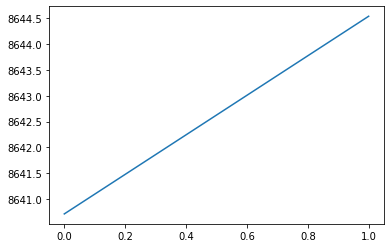

In [17]:
# training the model
cacheSR = trainMe(train_loader, model, optimizer, criterion, 2, cacheSR, device)

#saving the model
torch.save({
    'model_state_dict' : model.cpu().state_dict(),
    'cache' : cacheSR,
    },
    'models/UNET_SR_dipion_dict_v1.pt')

plt.plot(cacheSR['loss'])
plt.show()

In [ ]:
#on colab, download the generated sample
files.download('models/UNET_SR_dipion_dict_v1.pt')  

In [ ]:
plt.plot(cacheSR['loss'])
plt.show()

In [ ]:
#saving the model
torch.save({
    'model_state_dict' : model.cpu().state_dict(),
    'cache' : cacheSR,
    },
    'models/UNET_SR_dipion_dict_v1.pt')

### Continue training the model

with different learning rate

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.025
cacheSR = trainMe2(train_loader, model, optimizer, criterion, 120, cacheSR, device)
plt.plot(cacheSR['loss'])
plt.show()

# Ploting the results

Now we will plot the obtained results of the SR images. The results will be later tested in the downstream task.

In case we have newly trained model, we would like first to load the trained weights:

In [ ]:
#load model
checkpoint = torch.load('models/UNET_SR_dipion_dict_v1.pt')
model.load_state_dict(checkpoint['model_state_dict'])
cacheSR = checkpoint['cache']
model.train()
print('model loaded')

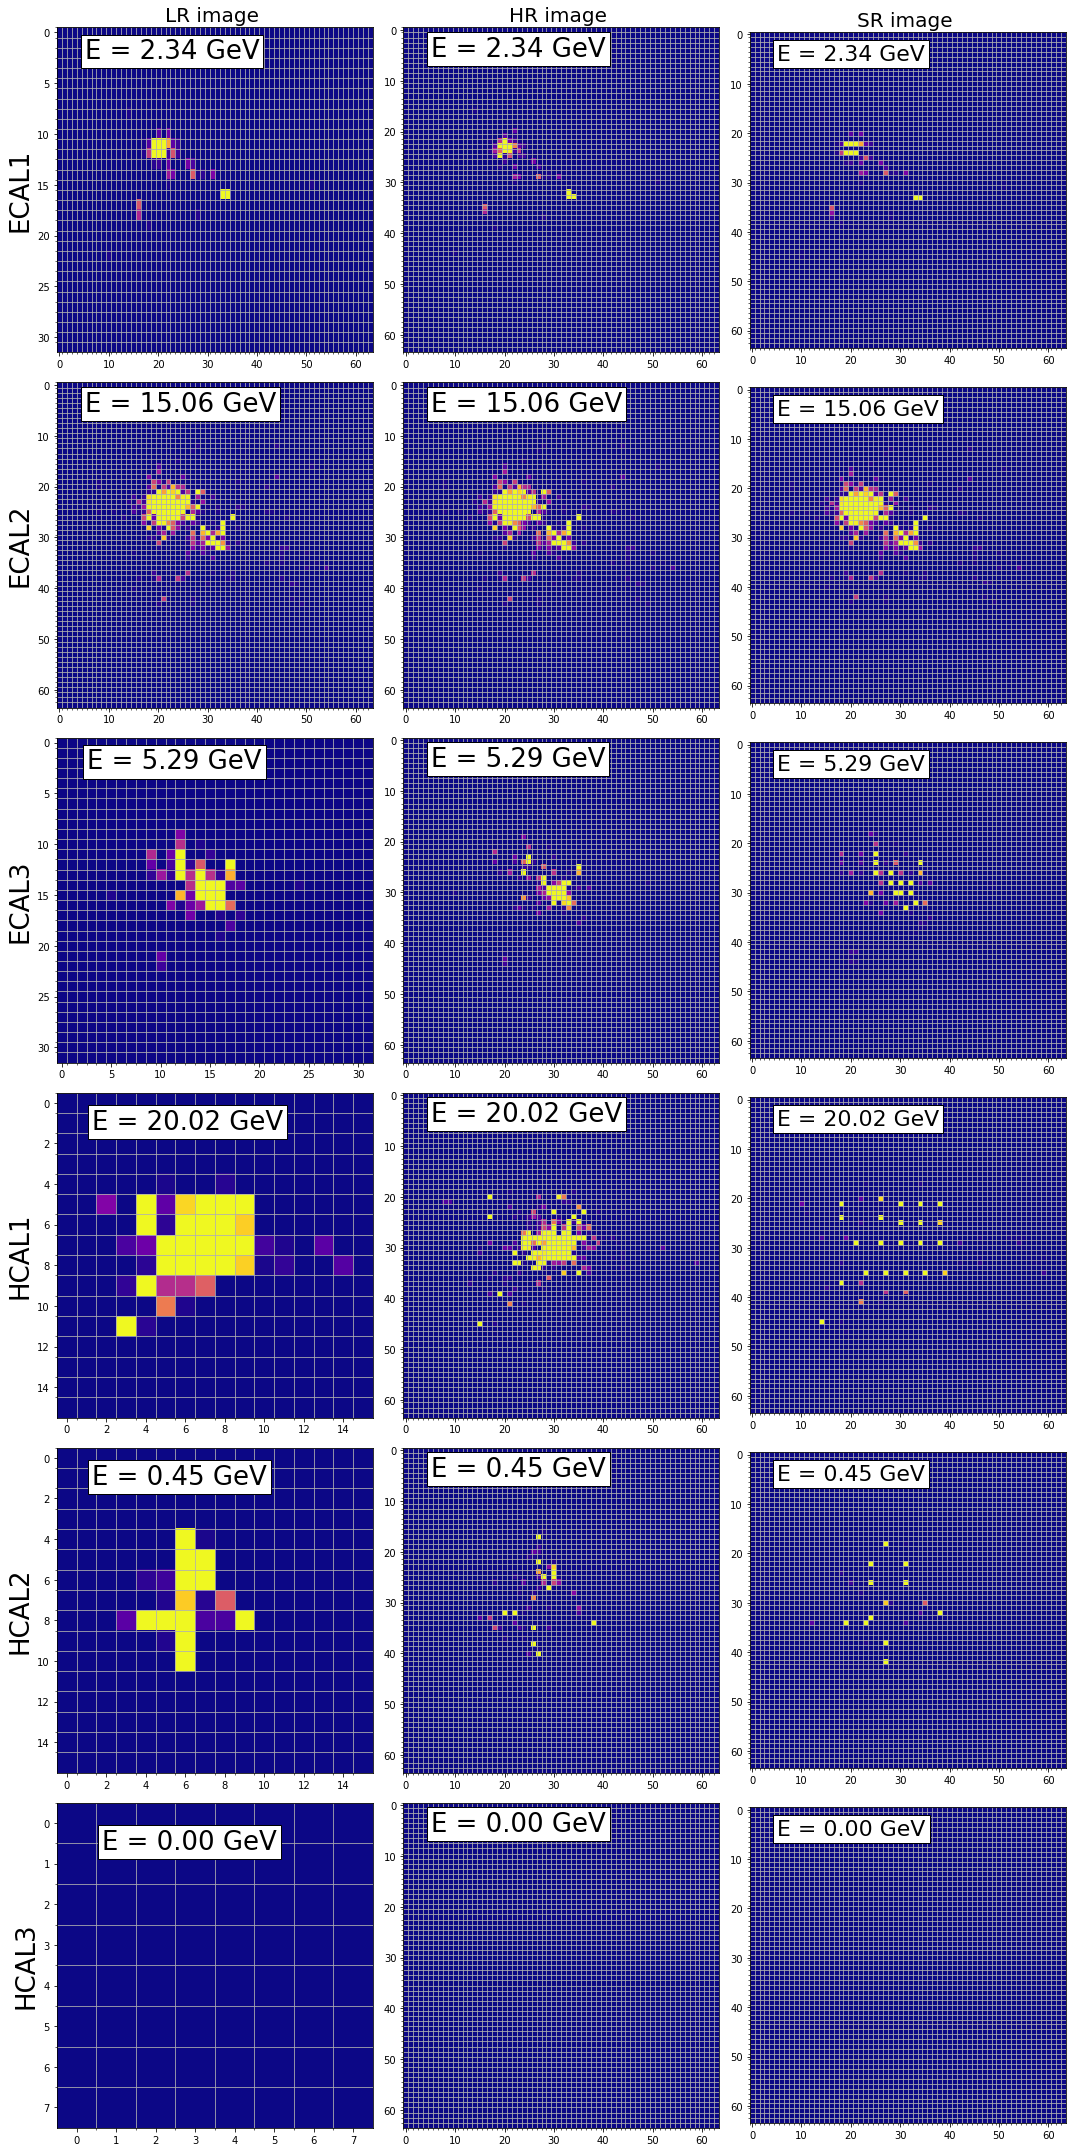

In [31]:
DrawEventSR2(train_dataset, event_number = 123, model = model)